In [1]:
import sqlite3
import random
from string import punctuation

import pandas as pd
import numpy as np
from pandas.core.series import Series
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
offers_connection = sqlite3.connect('../../datasets/offers_dataset.db')
offers_frame = pd.read_sql_query('''SELECT * FROM offers''', offers_connection)
offers_connection.close()

with sqlite3.connect('../../datasets/skills_dataset.db') as skills_connection:
    skills_frame = pd.read_sql_query('SELECT * FROM skills', skills_connection)
    skills_frame.set_index('ID', inplace=True)

In [3]:
offers_frame.dropna(subset='Name',inplace=True)
offers_frame.drop_duplicates(inplace=True)
offers_frame

,Name,Description,Location
0,Software Developer,Miniclip is a global leader in digital games w...,"Genova, Liguria"
1,Junior Software Developer,"NETtoWORK, azienda italiana nata nel 2016, ope...",17100 Savona
2,Software Developer,We are looking for talented and passionate peo...,55100 Lucca
3,Software Developer,ARESYS is a R&D oriented company with nearly ...,"Matera, Basilicata"
4,Senior Software Developer,Il/la Candidato/a dovrà padroneggiare: \n \n- ...,"Catania, Sicilia"
...,...,...,...
587,Python Software Engineer,Now is an amazing time to join Nozomi Networks...,"Milano, Lombardia"
588,Software Engineer,"Who we are:At Mambu, we believe that banking a...","Provincia di Latina, Lazio"
589,R&D Labeling Principal Engineer,This is where you save and sustain lives \n ...,"Medolla, Emilia-Romagna"
590,Workspace & Endpoint Deployment - System Engineer,Intesa Sanpaolo è un gruppo bancario internazi...,"Milano, Lombardia"


In [4]:
def remove_symbols(description: str, remove_map: dict) -> str:
    """
    """
    for old, new in remove_map.items():
        description = description.replace(old, new)
    return description.lower()


def extract_symbols(description: str, available_symbols: list) -> set:
    s = set()
    prev = ''
    for word in description.split():
        if word in available_symbols:
            s.add(word)
        elif f'{prev} {word}' in available_symbols:
            s.add(f'{prev} {word}')  
        prev = word
    return s 

def translate_skills(skills: set, toId = False) -> set:
    if toId:
        return skill_to_id(skills)
    else:
        return id_to_skill(skills)

def id_to_skill(skills: set[int]) -> set[str]:
    out = set()
    for skill in skills:
        out.add(skills_frame.loc[skill, 'SKILL'])
    
    return out

def skill_to_id(skills: set[str]) -> set[int]:
    out = set()
    for skill in skills:
        out.add(
            list(
                skills_frame.loc[
                    skills_frame['SKILL'].apply(lambda val: val.lower()) == skill.lower()
                ].index
            )[0]
        )
    
    return out

In [5]:
# Get Skill list
skills_list = [skill.lower() for skill in skills_frame['SKILL'].tolist()]

# Symbols to remove
punct = [p for p in punctuation]
punct.remove('+')
punct.remove('#')
# punct.remove('.')

removal = {p: ' ' for p in punct}
removal['\n'] = ' '
removal['/'] = ' '
removal['('] = ' '
removal[')'] = ' '
removal[','] = ' '
removal['>'] = ' '
removal['.'] = ' .'

In [6]:
required_skills = [] 

# Extract skills from descriptions and add new column
for i, offer_description in enumerate(offers_frame.loc[:, 'Description']):
    desc = remove_symbols(offer_description, removal)
    offer_skills = extract_symbols(desc, skills_list)
    required_skills.append(translate_skills(offer_skills, toId=True))  
    #required_skills.append(offer_skills)
offers_frame.insert(len(offers_frame.columns), "RequiredSkills", required_skills)

# Remove offers with no required skills
offers_frame['RequiredSkills'] = offers_frame['RequiredSkills'].apply(lambda x: np.NaN if not x else x)
offers_frame.dropna(subset='RequiredSkills', inplace=True)
offers_frame.reset_index(drop=True, inplace=True)
offers_frame

,Name,Description,Location,RequiredSkills
0,Software Developer,Miniclip is a global leader in digital games w...,"Genova, Liguria","{100, 101}"
1,Junior Software Developer,"NETtoWORK, azienda italiana nata nel 2016, ope...",17100 Savona,"{2, 6, 7, 8, 9}"
2,Software Developer,We are looking for talented and passionate peo...,55100 Lucca,"{0, 3, 6, 44, 26}"
3,Software Developer,ARESYS is a R&D oriented company with nearly ...,"Matera, Basilicata","{8, 9, 2}"
4,Senior Software Developer,Il/la Candidato/a dovrà padroneggiare: \n \n- ...,"Catania, Sicilia","{0, 1, 3, 99, 6, 7, 104, 55, 57, 26}"
...,...,...,...,...
477,IT On-Site Support Engineer,IT On-Site Support EngineerFunctional area: In...,"Milano, Lombardia",{103}
478,Python Software Engineer,Now is an amazing time to join Nozomi Networks...,"Milano, Lombardia","{73, 89, 2, 30}"
479,Software Engineer,"Who we are:At Mambu, we believe that banking a...","Provincia di Latina, Lazio","{30, 6, 31}"
480,Workspace & Endpoint Deployment - System Engineer,Intesa Sanpaolo è un gruppo bancario internazi...,"Milano, Lombardia",{103}


### Jaccard Distance

In [7]:
def _jaccard(s1: set, s2: set):
    return 1 - (len(s1.intersection(s2)) / len(s1.union(s2)))

def jaccard(row1: Series, row2: Series, col_name: str):
    if row1.keys().values is not row2.keys().values:
        raise ValueError(f'Rows have different columns: {row1.keys()} vs {row2.keys()}')   
    if col_name not in row1.keys() or col_name not in row2.keys():
        raise ValueError(f'Invalid Column Name {col_name}')  
    return _jaccard(row1[col_name], row2[col_name])

In [8]:
# Examples
r1 = offers_frame.loc[8, :]
r2 = offers_frame.loc[37, :]
r3 = offers_frame.loc[random.randint(0, len(offers_frame))]
r4 = offers_frame.loc[random.randint(0, len(offers_frame))]

print(f'Distance between {r1["Name"]} and {r1["Name"]}: {jaccard(r1, r1, "RequiredSkills"):.2f}\n {r1["RequiredSkills"]} and {r1["RequiredSkills"]}')
print(f'Distance between {r1["Name"]} and {r2["Name"]}: {jaccard(r1, r2, "RequiredSkills"):.2f}\n {r1["RequiredSkills"]} and {r2["RequiredSkills"]}')
print(f'Distance between {r3["Name"]} and {r4["Name"]}: {jaccard(r3, r4, "RequiredSkills"):.2f}\n {r3["RequiredSkills"]} and {r4["RequiredSkills"]}')

Distance between Frontend and Frontend: 0.00
 {0, 1, 99} and {0, 1, 99}
Distance between Frontend and Software Developer Degree Apprenticeship (Nottingham): 1.00
 {0, 1, 99} and {6, 7, 9, 57, 30}
Distance between QA Engineer H/F and 2024 Intern - Software Development Engineering: 1.00
 {32, 9, 18, 41} and {8, 6}


## Distance Matrix

In [9]:
def get_distance_matrix(frame: pd.DataFrame, col_name: str):
    distances = []
    for i, row1 in frame.iterrows():
        distances.append([])
        for j, row2 in frame.iterrows():
            if i != j:
                distances[-1].append(_jaccard(row1[col_name], row2[col_name]))
            else:
                distances[-1].append(0)#np.inf) 
    return pd.DataFrame(distances, index=frame.index, columns=frame.index)

distance_matrix = get_distance_matrix(offers_frame, 'RequiredSkills')

In [10]:
distance_matrix

,0,1,2,3,4,5,6,7,8,9,...,472,473,474,475,476,477,478,479,480,481
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0
1,1.0,0.000000,0.888889,0.400000,0.846154,0.833333,0.600000,1.000000,1.000000,0.833333,...,1.000000,0.888889,0.777778,0.933333,0.833333,1.0,0.875000,0.857143,1.0,1.0
2,1.0,0.888889,0.000000,1.000000,0.636364,0.833333,0.833333,1.000000,0.857143,0.833333,...,0.833333,0.888889,1.000000,0.857143,1.000000,1.0,1.000000,0.857143,1.0,1.0
3,1.0,0.400000,1.000000,0.000000,1.000000,1.000000,0.750000,1.000000,1.000000,1.000000,...,1.000000,0.857143,0.714286,0.923077,0.750000,1.0,0.833333,1.000000,1.0,1.0
4,1.0,0.846154,0.636364,1.000000,0.000000,0.800000,0.909091,1.000000,0.700000,0.909091,...,0.800000,0.846154,1.000000,0.687500,1.000000,1.0,1.000000,0.916667,1.0,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.0
478,1.0,0.875000,1.000000,0.833333,1.000000,1.000000,0.800000,1.000000,1.000000,1.000000,...,1.000000,0.875000,0.750000,0.846154,0.500000,1.0,0.000000,0.833333,1.0,1.0
479,1.0,0.857143,0.857143,1.000000,0.916667,0.750000,0.750000,1.000000,1.000000,0.750000,...,1.000000,1.000000,0.714286,0.923077,0.750000,1.0,0.833333,0.000000,1.0,1.0
480,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.0


In [11]:
def similar_offers(offer_id: int, threshold: float = 0.6) -> list:
    """
    get similar offers based only on distance matrix
    """
    similar = []
    for item_id, distance in distance_matrix.iloc[offer_id].sort_values()[offer_id:].items():
        if distance > threshold:
            break
        similar.append(offers_frame.iloc[item_id])
    return similar

### Clustering based recommendation

**Silhouette Score**

Per valutare il clustering effettuato useremo il Silhouette Score invece dell'Elbow Point dato che è che il punto di gomito è meno efficace, di solito, con dati complessi, inoltre il Silhouette Score fornisce più dettagli riguardo alle relazioni, in particolare alla separazione, tra cluster.

Per interpretare i risultati del Silhouette Score è importante notare che i valori, che variano da -1 a +1 hanno i seguenti significati:
-  1: Gli Item sono assegnati a un cluster specifico e i cluster sono facilmente distinguibili.
-  0: I cluster si sovrappongono.
- -1: Gli Item vengono assegnati a cluster errati.

L'algoritmo di clustering proposto è il KMeans, questo perchè ...
Per scegliere il valore di *k* abbiamo deciso di provare a calcolare il punteggio di Silhouette per diversi valori di *k* e scegliere quello con il risultato migliore.

In [12]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean


def item_cluster_distance(frame: pd.DataFrame, item: Series, target: int, 
                          group_label: str = 'Group', 
                          distance_label: str = 'RequiredSkills'):
    """
    Computes distance between an item in a cluster X and the other items in a cluster Y.
    Used also when X and Y are the same clusters.
    """
    group = frame[frame[group_label] == target]
    den = len(list(group.index))
    distance = 0
    
    for it in group.iterrows():
        if not it[1].equals(item):
            distance += jaccard(item, it[1], distance_label)
    
    return distance/den

def find_nearest_cluster(centroids, target_label: int):
    nearest = None
    target_centroid = centroids.iloc[target_label]
    min_dist = float('inf')
    
    for label, vector in centroids[centroids.index != target_label].iterrows():
        dist = euclidean(target_centroid, vector)
        if dist < min_dist:
            min_dist = dist
            nearest = label
    
    return nearest


def kmeans_silhouette(frame: pd.DataFrame,
               clustering: KMeans,
               group_label: str = 'Group',
               distance_label: str = 'RequiredSkills'):
    
    silhouette_scores = []
    for target_cluster in list(np.unique(frame[group_label])): 
        nearest_cluster = find_nearest_cluster(
            pd.DataFrame(clustering.cluster_centers_),
            target_cluster
        )
        for _, item in frame.iterrows():
            a = item_cluster_distance(frame, item, target_cluster, group_label, distance_label)
            b = item_cluster_distance(frame, item, nearest_cluster, group_label, distance_label)
            silhouette_score = (b - a) / max(a, b)
            silhouette_scores.append(silhouette_score)
    
    return np.mean(silhouette_scores)

In [13]:
# --- See how many clusters perform the best
max_value = -2
best_value = 0
for k in range(3, 7):
    tmp_kmeans = KMeans(n_clusters=k, init='k-means++', n_init=5, random_state=42)
    labels = tmp_kmeans.fit_predict(distance_matrix)
    offers_frame['Group'] = labels
    
    value = kmeans_silhouette(offers_frame, tmp_kmeans)
    print(f'Value for {k}: {value:.3f}')
    if value > max_value:
        max_value = value
        best_value = k

"\nmax_value = -2\nbest_value = 0\nfor k in range(3, 7):\n    tmp_kmeans = KMeans(n_clusters=k, init='k-means++', n_init=5, random_state=42)\n    labels = tmp_kmeans.fit_predict(distance_matrix)\n    offers_frame['Group'] = labels\n    \n    value = kmeans_silhouette(offers_frame, tmp_kmeans)\n    print(f'Value for {k}: {value:.3f}')\n    if value > max_value:\n        max_value = value\n        best_value = k\n"

In [22]:
# --- best
# k-means++ is best for high-dimensional data
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=42)
labels = kmeans.fit_predict(distance_matrix)
offers_frame['Group'] = labels

**Visualizzazione dei Cluster**

Visualizzare i risultati è importante per poter trarre delle conclusioni sulla qualità del clustering, la natura dei dati che bisogna visualizzare è però multidimensionale, questo può rendere arduo effettuare un plot; analizzando il problema possiamo dire che il nostro obbiettivo è *poter associare delle coordinate (x, y) a ogni Offerta nel dataset*, in particolare sfruttando la matrice delle distanze.
Per fare ciò useremo la riduzione delle dimensionalità tramite **Principal Component Analysis**. 

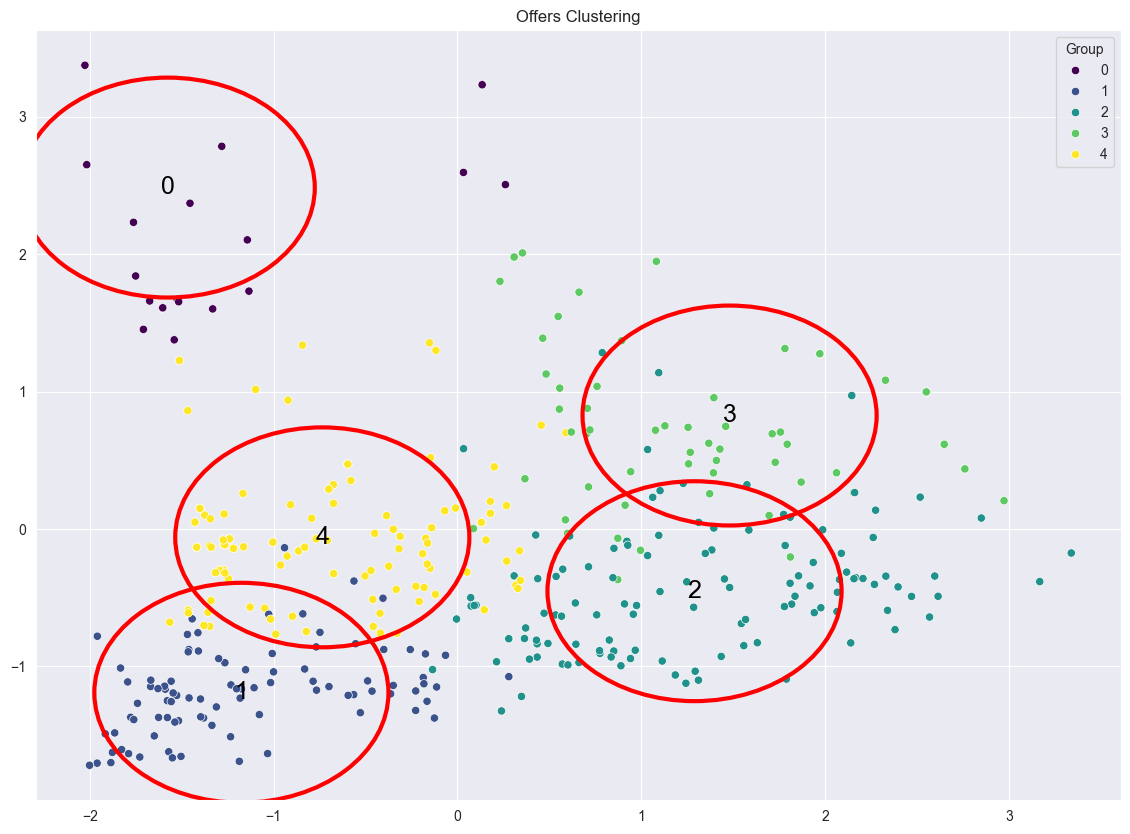

In [23]:
from sklearn.decomposition import PCA
from matplotlib.patches import Circle


pca = PCA(2)
group_labels = offers_frame['Group']
reduced_data = pca.fit_transform(distance_matrix)

plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data[:,0], y=reduced_data[:,1], hue=group_labels, palette='viridis')
plt.title('Offers Clustering')

groups = group_labels.unique()
for group in groups:
    group_data = reduced_data[labels == group]
    mean_x = group_data[:, 0].mean()
    mean_y = group_data[:, 1].mean()
    circle = Circle((mean_x, mean_y), 0.8, fill=False, linewidth=3, edgecolor='red', )
    plt.gca().add_artist(circle)
    plt.text(mean_x, mean_y, str(group), ha='center', va='center', fontsize=18, color='black')

plt.show()

Dopo aver analizzato lo scatterplot si è concluso che 6 cluster non erano buoni, in quanto due erano *"accavallati"*, quindi nonostante il punteggio di Silhouette fosse più alto si è optato per un **k = 5**, ottenendo così risultati migliori. 
***Nota**: abbiamo usato dei cerchi per evidenziare i gruppi, ma non sono rappresentativi della forma dei cluster, inoltre hanno una dimensione scelta in modo casuale*

In [27]:
tmp: pd.DataFrame = offers_frame[offers_frame['Group'] == 3]
tmp['RequiredSkills'] = tmp['RequiredSkills'].apply(lambda s: id_to_skill(s))
tmp

C:\Users\anton\AppData\Local\Temp\ipykernel_44468\894528445.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['RequiredSkills'] = tmp['RequiredSkills'].apply(lambda s: id_to_skill(s))


,Name,Description,Location,RequiredSkills,Group
6,IBP Junior Algorithms Software Development,Pirelli is looking for the following profile t...,"Bari, Puglia","{Python, Java}",3
17,Manufacturing Software Engineer / Relocation USA,The Manufacturing Software Engineer will work ...,"Torino, Piemonte","{Java, C++, Python, SQL, MySQL, C#}",3
20,Sviluppatore software,Cosa stiamo cercando \n Stiamo selezionando u...,37138 Verona,"{Python, SQL, JavaScript, PHP}",3
42,"System Software Engineer, Summer Intern - 2024...",ResponsibilitiesTikTok is the leading destinat...,London,"{Java, C++, Python, Linux, Rust, C}",3
46,Quality Assurance/Manual Testing,Career Level: 08 CareerPosting Date: 27 Dec 20...,None,"{Java, Azure, Python, .NET, SQL, Visual Studio...",3
...,...,...,...,...,...
454,Big Data Engineer - Sede di Napoli,Data pubblicazione: 23/01/2024 \n Riferimen...,"Napoli, Campania","{Google Cloud, Java, Python, Kafka}",3
459,Solution Engineer (different levels available)...,"To get the best candidate experience, please c...","Milano, Lombardia","{Python, Pandas, C}",3
462,Cloud Infrastructure Engineer - GCP - Remote,Company DescriptionInPost Group is an innovat...,None,"{Java, C++, JavaScript, Ruby, Python, SQL, Ter...",3
465,Junior Data Engineer,"Ricerchiamo, per un nostro importante cliente ...",None,"{Python, SQL, Git}",3


**Esempi**

In [18]:
def _similar_offers_with_cluster(offer_id: int) -> list:
    target_group = offers_frame.loc[offer_id, 'Group']
    return list(
        offers_frame[
            offers_frame['Group'] == target_group
        ].index
    )

def similar_offers_with_cluster(offer_id: int) -> list:
    return [offers_frame.iloc[oid] for oid in _similar_offers_with_cluster(offer_id)]
offers_frame

,Name,Description,Location,RequiredSkills,Group
0,Software Developer,Miniclip is a global leader in digital games w...,"Genova, Liguria","{100, 101}",1
1,Junior Software Developer,"NETtoWORK, azienda italiana nata nel 2016, ope...",17100 Savona,"{2, 6, 7, 8, 9}",2
2,Software Developer,We are looking for talented and passionate peo...,55100 Lucca,"{0, 3, 6, 44, 26}",4
3,Software Developer,ARESYS is a R&D oriented company with nearly ...,"Matera, Basilicata","{8, 9, 2}",2
4,Senior Software Developer,Il/la Candidato/a dovrà padroneggiare: \n \n- ...,"Catania, Sicilia","{0, 1, 3, 99, 6, 7, 104, 55, 57, 26}",4
...,...,...,...,...,...
477,IT On-Site Support Engineer,IT On-Site Support EngineerFunctional area: In...,"Milano, Lombardia",{103},1
478,Python Software Engineer,Now is an amazing time to join Nozomi Networks...,"Milano, Lombardia","{73, 89, 2, 30}",0
479,Software Engineer,"Who we are:At Mambu, we believe that banking a...","Provincia di Latina, Lazio","{30, 6, 31}",0
480,Workspace & Endpoint Deployment - System Engineer,Intesa Sanpaolo è un gruppo bancario internazi...,"Milano, Lombardia",{103},1


In [19]:
# Frontend: {css, javascript, html}
print(f'Offers Similar to {offers_frame.iloc[8]["Name"]}:\n')
for i, o in enumerate(similar_offers_with_cluster(8)):
    print(f'{i}> {o["Name"]} : {id_to_skill(o["RequiredSkills"])}')

Offers Similar to Frontend:

0> Software Developer : {'Java', 'JavaScript', 'SQL', 'Angular', 'Oracle'}
1> Senior Software Developer : {'Java', 'HTML', 'JavaScript', '.NET', 'SQL', 'Linux', 'AngularJS', 'Oracle', 'CSS', 'C#'}
2> Frontend : {'CSS', 'HTML', 'JavaScript'}
3> JUNIOR DEVELOPER : {'HTML', 'JavaScript', 'jQuery', '.NET', 'SQL', 'CSS', 'C#'}
4> Stage Software Developer : {'Java', 'JavaScript', 'React', 'Kafka', 'Spring', 'Google Cloud', 'Kubernetes', 'Docker', 'PHP'}
5> Software Developer : {'TypeScript', 'Angular', 'AWS', 'React'}
6> Front-End - App Developer : {'Flutter', 'JavaScript', 'iOS', 'React', 'TypeScript', 'AWS', 'Azure', 'Git', 'Dart', 'Angular', 'Oracle', 'React Native'}
7> Full Stack Developer : {'JavaScript', 'React', 'AWS', 'Python', 'PostgreSQL', 'SQL', 'Git', 'Django', 'Webpack', 'MySQL', 'Docker', 'CSS', 'Vite'}
8> L4 Software Developer Apprentice : {'HTML', 'JavaScript', 'Git', 'C', 'CSS', 'PHP'}
9> Frontend Software Developer : {'HTML', 'Bash', 'React', 'J

In [20]:
# Machine Learning Ops/Engineer
print(f'Offers Similar to {offers_frame.iloc[240]["Name"]}:\n')
for i, o in enumerate(similar_offers_with_cluster(240)):
    print(f'{i}> {o["Name"]} : {id_to_skill(o["RequiredSkills"])}')

Offers Similar to FULLREMOTE-Data Scientist (Time Series):

0> IBP Junior Algorithms Software Development : {'Python', 'Java'}
1> Manufacturing Software Engineer / Relocation USA : {'Java', 'C++', 'Python', 'SQL', 'MySQL', 'C#'}
2> Sviluppatore software : {'Python', 'SQL', 'JavaScript', 'PHP'}
3> Campus - Graduate Programme - Technology Graduate Software Engineer - 2024 (UK) : {'Java', 'Kotlin', 'Python', 'Spring', 'Express', 'CSS'}
4> System Software Engineer, Summer Intern - 2024 Start (Fixed-Term Contract) : {'Java', 'C++', 'Python', 'Linux', 'Rust', 'C'}
5> Quality Assurance/Manual Testing : {'Java', 'Azure', 'Python', '.NET', 'SQL', 'Visual Studio', 'C#'}
6> Cyber Security Analyst - Undergraduate : {'Python', 'Java', 'C'}
7> Software Engineer (University Grad) : {'Python', 'C++', 'Java', 'JavaScript'}
8> Electrochemical Modelling - Energy Storage Internship – Starting Summer 2024 (12 months) : {'Python'}
9> Macro Research Analyst and Associate Internship 2024 London : {'Python'}
1

In [21]:
# Machine Learning / Java Developer
print(f'Offers Similar to {offers_frame.iloc[237]["Name"]}:\n')
for i, o in enumerate(similar_offers_with_cluster(237)):
    print(f'{i}> {o["Name"]} : {id_to_skill(o["RequiredSkills"])}')

Offers Similar to Investigador predoctoral en Machine Learning:

0> IBP Junior Algorithms Software Development : {'Python', 'Java'}
1> Manufacturing Software Engineer / Relocation USA : {'Java', 'C++', 'Python', 'SQL', 'MySQL', 'C#'}
2> Sviluppatore software : {'Python', 'SQL', 'JavaScript', 'PHP'}
3> Campus - Graduate Programme - Technology Graduate Software Engineer - 2024 (UK) : {'Java', 'Kotlin', 'Python', 'Spring', 'Express', 'CSS'}
4> System Software Engineer, Summer Intern - 2024 Start (Fixed-Term Contract) : {'Java', 'C++', 'Python', 'Linux', 'Rust', 'C'}
5> Quality Assurance/Manual Testing : {'Java', 'Azure', 'Python', '.NET', 'SQL', 'Visual Studio', 'C#'}
6> Cyber Security Analyst - Undergraduate : {'Python', 'Java', 'C'}
7> Software Engineer (University Grad) : {'Python', 'C++', 'Java', 'JavaScript'}
8> Electrochemical Modelling - Energy Storage Internship – Starting Summer 2024 (12 months) : {'Python'}
9> Macro Research Analyst and Associate Internship 2024 London : {'Pytho